# Time Series Analysis and Forecasting

In [10]:
# imports
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

## 1. Load and Prep Data

In [11]:
# importing data
birth = pd.read_table('data/birth.txt')
# checking
birth.head()

,num_births
0,295
1,286
2,300
3,278
4,272


In [12]:
# creating a dates variable (from January 1980 and ending December 2010).
dates = pd.date_range(start='1/1/1980', end='12/31/2010', freq='M')

In [14]:
# setting the dates variable as the index of your dataframe
birth = birth.set_index(dates)
birth.head()

,num_births
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


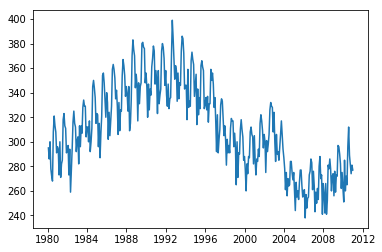

In [15]:
plt.plot(birth)

## 2. Split into Train-Test

Time series data cannot be evaluated using traditional cross validation methods. That leaves us with two options: (1) Splitting the data manually using a certain point in time as our division line between 'past' observations (the training set) and 'future' values (the testing set we can measure our forecasts against). (2) Splitting data into multiple training/testing folds using TimeSeriesSplit from the sklearn library.

Observations: 372
Training Observations: 245
Testing Observations: 127


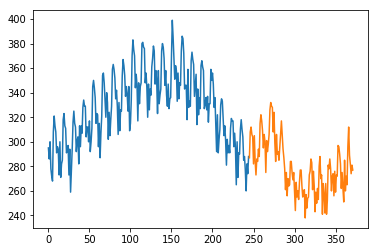

In [16]:
# splitting into training and testing sets using 66-34
X = birth.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

# then plotting it using different colors
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

In [17]:
# made train_df and test_df (the latter to be used later)
train_df = birth[0:245]
train_df.head()
test_df = birth[245:372]

## 4. Time Series Decomposition

can have trend, seasonal, residual <br>
$y_t = T_t+ S_t+\epsilon_t$ <br>
can be additive or multiplicative (can use different forecasting methods accordingly) <br>

statsmodel has a seasonal_decompose() function, it will show observed, can call trend, seasonal, and residual <br>
print(result.trend) <br>
print(result.seasonal) <br>
print(result.resid) <br>
print(result.observed) <br>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_a = seasonal_decompose(series, model='additive')
result_a.plot()
plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = birth
result_m = seasonal_decompose(series, model='multiplicative')
result_m.plot()
plt.show()

Note that the various components are on different scale. The trend is roughly on the same scale as the observations, but seasonal fluctuations and residuals are on a different scale. Talk about error distributions. Maybe look at QQ-plots? These are very bad--shows that classical decomposition is not powerful enough to capture whatever was happening starting 2008.

## 5.3. Forecasting Methods: ARIMA

ARIMA uses autocorrelation. If a time series is stationary (see concept below), the correlation between two $y$'s only depends on the lag between them. These correlations between a time series and a lagged version of itself are called autocorrelations. Some exponential smoothing models have ARIMA equivalents and vica versa. (This book gives you the ARIMA-ETS equivalences: https://www.otexts.org/fpp/7/6)

### Stationarity

Image courtesy of www.seanabu.com) <br>

![test](https://static1.squarespace.com/static/53ac905ee4b003339a856a1d/t/5818f84aebbd1ac01c275bac/1478031479192/?format=1500w)

To test for stationarity: use Augmented Dickey-Fuller test (hypothesis test)<br>
$H_0$: time series is not stationary. <br>
$H_a$: time series is stationary

In [ ]:
test=sm.tsa.stattools.adfuller(train_df['num_births'])
print("ADF p-value for training series: {0:2.2f}".format(test[1]))

### ARIMA Components

A non-seasonal ARIMA model: combines differencing with autoregression and a moving average model
* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. <br>

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

### (1) Differencing

In [ ]:
# differencing: computing the differences between t and t-1 observations
train_df_diff = train_df['num_births'].diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

In [ ]:
# let's do it again!
train_df_diff2 = train_df_diff.diff()[1:]

# running ADF test to see if it made a difference
test = sm.tsa.stattools.adfuller(train_df_diff2)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

### (2) Moving Average Modeling

$X_t=\mu+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q} = \displaystyle\sum_{i=1}^{q} \theta_i\epsilon_{t-i} +\mu$ <br>

$\epsilon_t$: noise <br>
$\theta_1\epsilon_{t-1}$: yesterday's noise <br>
$\theta_q\epsilon_{t-q}$: noise from $q$ days ago <br>
moving average models are always stationary <br>
how do I get $q$? I plot autocorrelation -- if it is a MA(q) model, it drops off at $q$ <br>
how do I get $\theta$? regression gives me the coefficients

In [ ]:
# moving average MA modeling
from statsmodels.tsa.arima_model import ARIMA
series = train_df

# fit model
model = ARIMA(series, order=(0,0,1)) #the third parameter is the MA order (q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# let's plot the residuals
# line plot of residual errors
# (suggests that there is still trend & seasonality not captured by the model)
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

In [ ]:
# density plot of residual errors
#(suggests the errors are not quite Gaussian, but are centered on zero)
residuals.plot(kind='kde')

In [ ]:
# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(series, lags=2*52, ax=ax)

### (3) Autoregressive Modeling

$X_t=\epsilon_t+\phi_1 X_{t-1}+...+\phi_p X_{t-p} = \displaystyle\sum_{i=1}^{p} \phi_iX_{t-i} +\epsilon_t$ <br>
$\phi_1 X_{t-1}$: yesterday's value <br>
$phi_p X_{t-p}$: value $p$ days ago
autoregressive models aren't always stationary (depends on $\phi$ parameter) <br>
how do I get $p$? autocorrelation always has exponential decay, so that doesn't help <br>
I plot partial autocorrelation -- if it is an AR(p) model, it drops off at $p$ <br>
how do I get $\phi$? regression gives me the coefficients

In [ ]:
# autoregression AR modeling
# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(series, lags=2*52, ax=ax)

ARIMA - you take a difference until you get an ARMA model <br>
$Y_t = \nabla^d X_t$ <br>
$X_t$: ARIMA model <br>
$\nabla^d$ differenced $d$ times <br>
creating $Y_t$ ARMA model <br>
$Y_t = \mu+\phi_1 Y_{t-1}+...+\phi_p Y_{t-p}+\epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q}$

Steps to ARIMA:
1. Visualize
2. Stationarize (check with Dickey-Fuller)
3. Find optimal parameters to p,d,q with ACF and PACF plots
4. Build ARIMA model
5. Predict and score

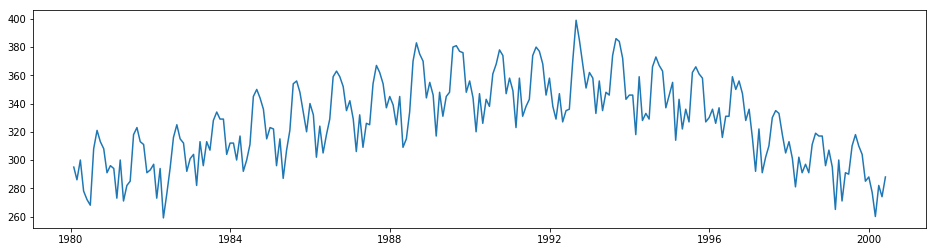

In [24]:
# visualize
plt.figure(figsize=(16,4))
plt.plot(train_df)

In [ ]:
# there's clearly a trend of growth until 1993 and then decline (differencing)
# there's also a seasonal component of a little more than 12 months
# variance seems to be stable but better check using tsa.decompose 
# (if it isn't, we can take a log)

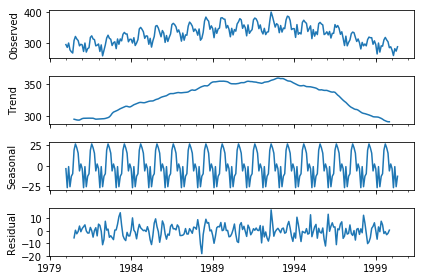

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = train_df
result_a = seasonal_decompose(series, model='additive')
result_a.plot()
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller
# differencing: computing the differences between t and t-1 observations
train_df_diff = train_df['num_births'].diff()[1:]

# running ADF test to see if it made a difference
test = adfuller(train_df_diff)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.06


In [28]:
# doing it again to remove more
train_df_diff2 = train_df_diff.diff()[1:]

# running ADF test to see if it made a difference
test = adfuller(train_df_diff2)
print("ADF p-value for differenced training series: {0:2.2f}".format(test[1]))

ADF p-value for differenced training series: 0.00


/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


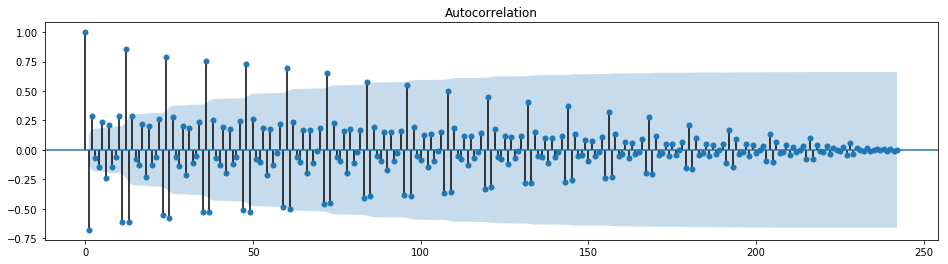

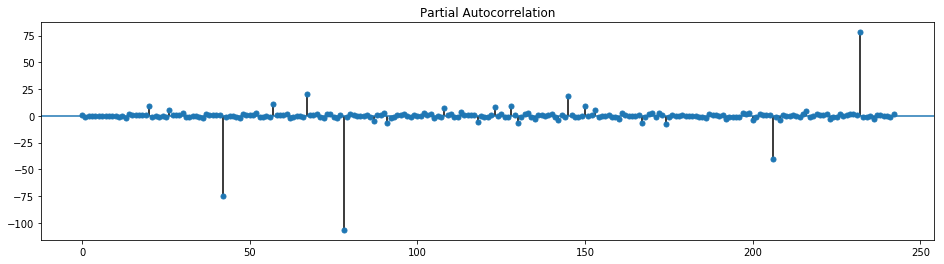

In [29]:
# now we can plot acf and pacf to get our p and q
series = train_df_diff2

# to see how many time periods to pick: plot autocorrelation and see where it drops off
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, figsize=(16,4))
_ = sm.graphics.tsaplots.plot_acf(series, lags=None, ax=ax)
fig, ax = plt.subplots(1, figsize=(16,4))
_ = sm.graphics.tsaplots.plot_pacf(series, lags=None, ax=ax)

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


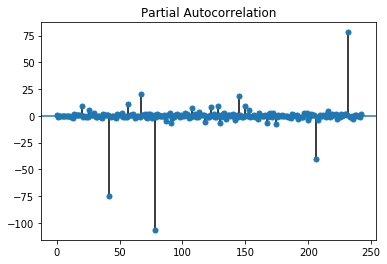

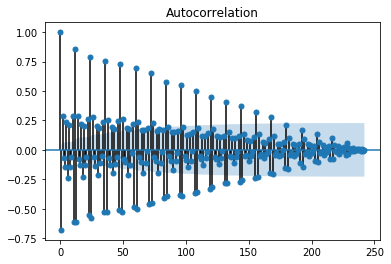

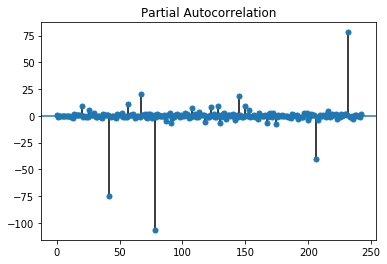

In [30]:
import statsmodels.tsa.api as smt
y = train_df_diff2
lags=None
smt.graphics.plot_acf(y, lags=lags, alpha=0.5)
smt.graphics.plot_pacf(y, lags=lags, alpha=0.5)

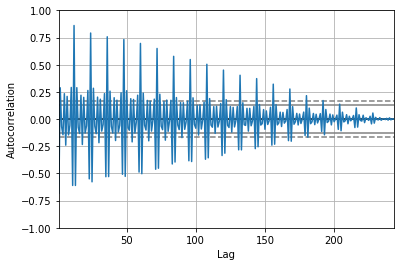

In [32]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

## Making Time Series Stationary

In [50]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def evaluate_stationarity(timeseries, t=30):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

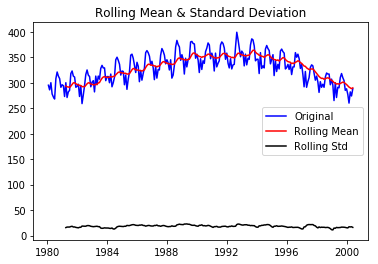

Results of Dickey-Fuller Test:
Test Statistic                  -1.102790
p-value                          0.713958
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [51]:
evaluate_stationarity(train_df['num_births'], 15)

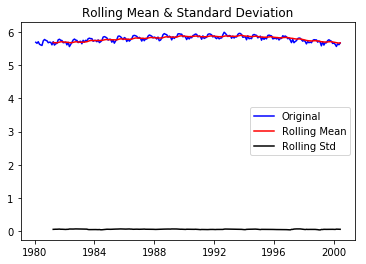

Results of Dickey-Fuller Test:
Test Statistic                  -1.064933
p-value                          0.728852
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [45]:
# applying transformations (log)
data_log = np.log(train_df['num_births'])
evaluate_stationarity(data_log, 15)

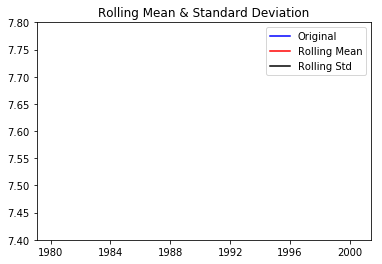

In [55]:
# zooming in -- DOESN'T WORK !!!
#Determing rolling statistics
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

#Plot rolling statistics:
orig = plt.plot(data_log, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.ylim([7.4,7.8])
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

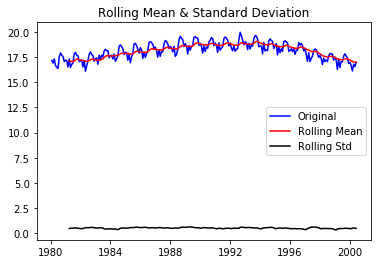

Results of Dickey-Fuller Test:
Test Statistic                  -1.085142
p-value                          0.720961
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [56]:
# applying transformations (sqrt)
data_sqrt = np.sqrt(train_df['num_births'])
evaluate_stationarity(data_sqrt, 15)

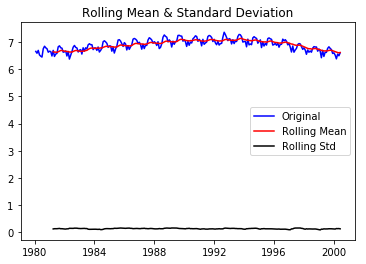

Results of Dickey-Fuller Test:
Test Statistic                  -1.078666
p-value                          0.723504
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [57]:
# applying transformations (cbrt)
data_cbrt = np.cbrt(train_df['num_births'])
evaluate_stationarity(data_cbrt, 15)

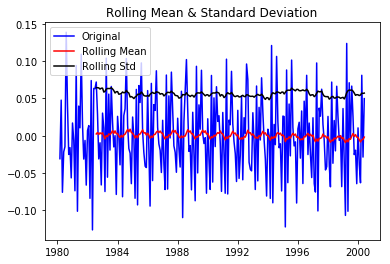

Results of Dickey-Fuller Test:
Test Statistic                  -2.791613
p-value                          0.059482
#Lags Used                      15.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


In [58]:
# log then differencing
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

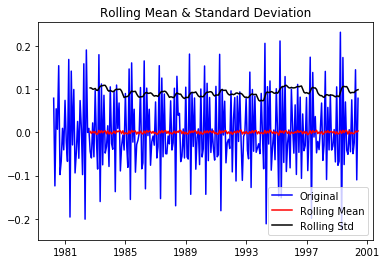

Results of Dickey-Fuller Test:
Test Statistic                -1.121755e+01
p-value                        2.051650e-20
#Lags Used                     1.400000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


In [59]:
# log then differencing second times
data_log_diff2 = data_log_diff - data_log_diff.shift()
data_log_diff2.dropna(inplace=True)
evaluate_stationarity(data_log_diff2)

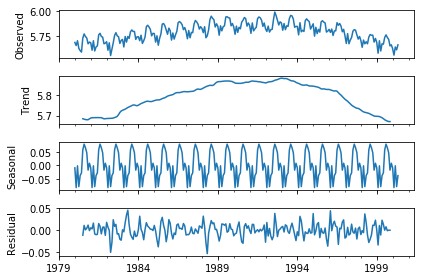

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_a = seasonal_decompose(data_log, model='additive')
result_a.plot()
plt.show()

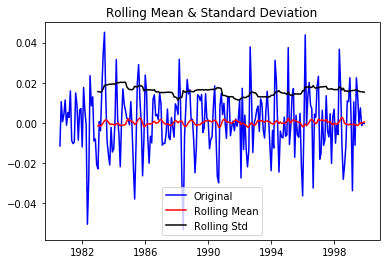

Results of Dickey-Fuller Test:
Test Statistic                -8.480178e+00
p-value                        1.400030e-13
#Lags Used                     7.000000e+00
Number of Observations Used    2.250000e+02
Critical Value (1%)           -3.459752e+00
Critical Value (5%)           -2.874473e+00
Critical Value (10%)          -2.573663e+00
dtype: float64


In [64]:
residual = result_a.resid
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

/Users/andreafabry/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


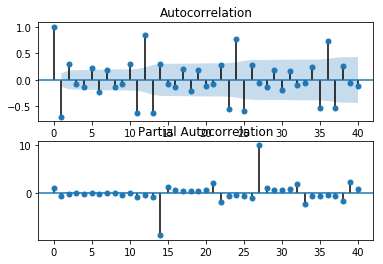

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ax1= plt.subplot(211)
fig = plot_acf(data_log_diff2.squeeze(), lags=40, ax=ax1)
ax2= plt.subplot(212)
fig = plot_pacf(data_log_diff2, lags=40, ax=ax2)